## Description:

 Code for RhizCG microbial community analysis to be presented at ESA, August 12th, 2015



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R

library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)



/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [6]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 68K
lrwxrwxrwx 1 bryan bryan  130 Nov  9 13:07 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Nov  9 13:07 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 9.7K Sep 29 18:03 NMDS_DAPfacet.pdf
-rw-rw-r-- 1 bryan bryan 8.0K Aug 11 19:58 facet_NMDS_w-enz.pdf
-rw-rw-r-- 1 bryan bryan 7.8K Aug 11 17:04 NMDS_plant_wunif.pdf
-rw-rw-r-- 1 bryan bryan 7.4K Aug 11 15:25 NMDS_full_wunif.pdf
-rw-rw-r-- 1 bryan bryan  22K Jul 27 13:53 heatmap_rank2.pdf


# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)

#apply gsub across columns to replace ___ w/ "", reload to phyloseq object
t = tax_table(physeq)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(physeq) = t

In [8]:
%%R
plantData = read.table('/home/bryan/RhizCG/data/MiSeq_amplicon/PlotData.txt', header = TRUE)
colnames(plantData)

 [1] "Unique"             "PlotID"             "Plant"             
 [4] "Plot"               "Treatment"          "Rep"               
 [7] "DAP"                "Sampling"           "PlantSample"       
[10] "Type"               "Grass_Broad"        "Status"            
[13] "Subfamily"          "Symbol_class"       "Plant_num"         
[16] "Leaf_AreaBiomass_g" "Biomass_T"          "Biomass_P"         
[19] "Leaf_Area_cm2"      "SLA"                "Leaf_N"            
[22] "Leaf_C"             "LeafC_N"            "LNa"               
[25] "Plant_N"            "Plant_C"            "Plant_CN"          
[28] "d15N"               "tN_p"               "SoilID"            
[31] "Moisture"           "PO_Activity"        "PER_Activity"      
[34] "PO_barefactor"      "PER_barefactor"     "PO_dif"            
[37] "PER_dif"            "PO_rel"             "PER_rel"           
[40] "BX_act"             "CB_act"             "LAP_act"           
[43] "NAG_act"            "BX_activity_g"      "

In [9]:
%%R


s = sample_data(physeq)
PD = plantData[,c(1,18, 20,21, 23:29, 44:47, 52:59)]
s2 = left_join(s, PD, by = c("X.sample" = "Unique"))
rownames(s2) = s2$X.sample
sample_data(physeq) = s2
sample_data(physeq) %>% head

Sample Data:        [6 samples by 43 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample2-1.06_Npos sample2-1.06_Npos       1            1             H9
sample6-4.27_Npos sample6-4.27_Npos       1            2            F11
sample4-4.27_Nneg sample4-4.27_Nneg       1            1            B12
sample4-1.06_Nneg sample4-1.06_Nneg       1            1            E11
sample2-1.06_Nneg sample2-1.06_Nneg       1            1             G9
sample6-3.07_Nneg sample6-3.07_Nneg       1            2            C11
                  primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
sample2-1.06_Npos                  72                72         72 1.06_Npos
sample6-4.27_Npos                  86               182        182 4.27_Npos
sample4-4.27_Nneg                  90                90         90 4.27_Nneg
sample4-1.06_Nneg                  85                85         85 1.06_Nneg
sample2-1.06_Nneg                  71                71

In [10]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))
#set DAP to factor
#sample_data(physeq)$DAP = factor(sample_data(physeq)$DAP)
print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 43 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


## Normalize samples and filter out taxa that are less than .1*length(x)

In [12]:
%%R 
# filtering/normalizing
physeq.snorm = prune_samples(sample_sums(physeq) >= 10, physeq)
physeq.snorm = transform_sample_counts(physeq.snorm, function(x) x/sum(x))
  
physeq.thresh = filter_taxa(physeq.snorm, function(x) sum(x > 0) > (0.01 * length(x)), TRUE)
print(physeq.snorm)
#physeq.thresh = physeq.snorm

print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 43 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10493 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 43 sample variables ]
tax_table()   Taxonomy Table:    [ 10493 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10493 tips and 10492 internal nodes ]


Notes: Threshold of 0.0001*length(x) removes 9 taxa, 0.01*length(x) results in 10493 taxa, 0.1*length results in 6736 taxa

## Calculate pairwise weighted Unifrac distances between samples

In [13]:
%%R
registerDoParallel(cores=28)
full.wunif.dist = phyloseq::distance(physeq.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [14]:
%%R
registerDoParallel(cores=28)
full.bray.dist = phyloseq::distance(physeq.thresh, 
                      method = "bray", 
                      parallel = TRUE, 
                      normalized = FALSE)

# NMDS of w-unif

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Saving 8.33 x 4.86 in image

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Run 0 stress 0.140416 
Run 1 stress 0.1577814 
Run 2 stress 0.1921723 
Run 3 stress 0.1549887 
Run 4 stress 0.1843943 
Run 5 stress 0.1779926 
Run 6 stress 0.1664623 
Run 7 stress 0.1629554 
Run 8 stress 0.1541747 
Run 9 stress 0.1803648 
Run 10 stress 0.1724225 
Run 11 stress 0.1802352 
Run 12 stress 0.1810028 
Run 13 stress 0.1547615 
Run 14 stress 0.1900168 
Run 15 stress 0.1562466 
Run 16 stress 0.16847 
Run 17 stress 0.154867 
Run 18 stress 0.1699836 
Run 19 stress 0.1540533 
Run 20 stress 0.1733542 


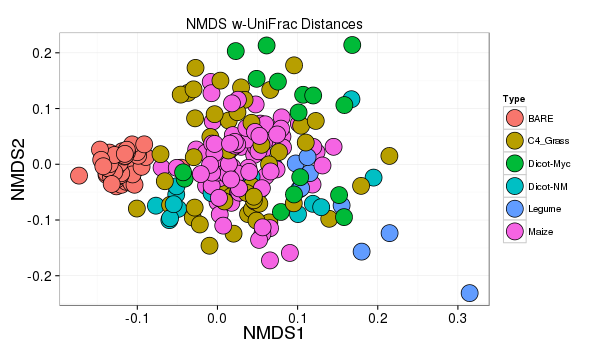

In [15]:
%%R -w 600 -h 350

nmds = ordinate(physeq.thresh, 
                method = "NMDS", 
                distance = full.wunif.dist)

p = plot_ordination(physeq.thresh, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Type), pch = 21, size = 8) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18)) +
        labs(title = "NMDS w-UniFrac Distances", size = 20)
        #scale_size(range=c(2,8))

##need arrange into a presentation quality graphic and save

grid.arrange(p1, ncol=1)
ggsave(filename = "NMDS_full_wunif.pdf", plot = p1)

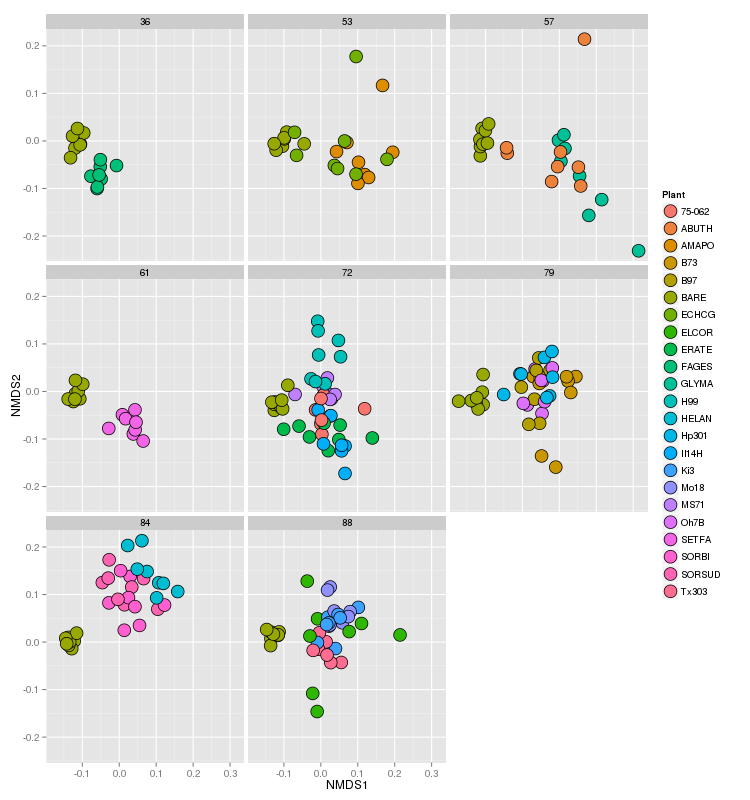

In [16]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

## Subset just plants to evaluate variation without bare soil

In [17]:
%%R

physeq.plant = subset_samples(physeq.thresh, Plant != "BARE")
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10493 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 43 sample variables ]
tax_table()   Taxonomy Table:    [ 10493 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10493 tips and 10492 internal nodes ]


In [18]:
%%R
#create maize/non-maize variable
sample_data(physeq.plant)$Maize = ifelse(sample_data(physeq.plant)$Type == "Maize", "Maize", 
                                         "Annuals")
sample_data(physeq.plant)$Maize = factor(sample_data(physeq.plant)$Maize)

In [19]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = phyloseq::distance(physeq.plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [20]:
%%R
registerDoParallel(cores=28)
plant.bray.dist = phyloseq::distance(physeq.plant, 
                      method = "bray", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

# NMDS of plant only w-UNIF

In [60]:
%%R -w 800 -h 350


nmds = ordinate(physeq.plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(physeq.plant, nmds, justDF = TRUE)
str(p)

Run 0 stress 0.1715457 
Run 1 stress 0.1865518 
Run 2 stress 0.1792416 
Run 3 stress 0.2016671 
Run 4 stress 0.181986 
Run 5 stress 0.186229 
Run 6 stress 0.1890878 
Run 7 stress 0.1854971 
Run 8 stress 0.1848505 
Run 9 stress 0.196494 
Run 10 stress 0.1867339 
Run 11 stress 0.2134223 
Run 12 stress 0.1868725 
Run 13 stress 0.1760468 
Run 14 stress 0.1774131 
Run 15 stress 0.1791337 
Run 16 stress 0.1868216 
Run 17 stress 0.1907248 
Run 18 stress 0.2054657 
Run 19 stress 0.1934041 
Run 20 stress 0.1821219 
'data.frame':	176 obs. of  46 variables:
 $ NMDS1              : num  -0.06217 -0.02534 -0.07699 -0.00494 -0.01422 ...
 $ NMDS2              : num  -0.0453 -0.0238 -0.0425 -0.0221 -0.011 ...
 $ X.sample           : chr  "sample5-1.22_Nneg" "sample6-4.12_Npos" "sample4-1.03_Npos" "sample5-2.06_Npos" ...
 $ Library            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Primer_Plate       : int  1 2 1 2 2 1 1 1 1 2 ...
 $ Primer_Well_ID     : Factor w/ 93 levels "A1","A10","A11",..: 7 87 18 37 83

In [22]:
%%R
#keepvariables = sample_data(physeq.plant)[,c(34:37,43)]
plantsd = data.frame(sample_data(physeq.plant))
colnames(plantsd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "Leaf_N"             
[25] "LeafC_N"             "LNa"                 "Plant_N"            
[28] "Plant_C"             "Plant_CN"            "d15N"               
[31] "tN_p"                "BX_activity_g"       "CB_activity_g"      
[34] "LAP_activity_g"      "NAG_activity_g"      "BX_dif"             
[37] "CB_dif"              "LAP_dif"             "NAG_dif"            
[40] "BX_rel"              "CB_rel"              "LAP_rel"            
[43] "

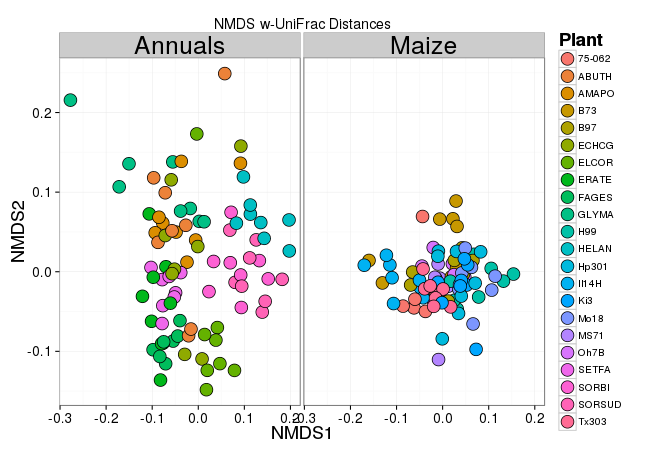

In [61]:
%%R -w 650 -h 450
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21, size = 6) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25)) +
        facet_wrap(~Maize) +
        labs(title = "NMDS w-UniFrac Distances", size = 20) +
        theme(legend.title = element_text(colour = 'black', angle = 0, size = 18, 
                                          hjust = 3, vjust = 7, face = 'bold')) +
        theme(legend.text = element_text(size = 10))
        #title.theme = element_text(size = 12, face = "bold") 
p1
#ggsave(filename = "NMDS_plant_wunif.pdf", plot = p1)

## Now overlay enzyme data

In [26]:
%%R
#keepvariables = sample_data(physeq.plant)[,c(34:37,43)]
plantsd = data.frame(sample_data(physeq.plant))
colnames(plantsd)
plantenz = plantsd[,32:35] #select enzyme activity data

In [27]:
%%R
#drop_out = plantenz$NAG_activity_g <40

#penz_d = plantenz[drop_out,]
cor(plantenz)


               BX_activity_g CB_activity_g LAP_activity_g NAG_activity_g
BX_activity_g      1.0000000     0.8415760      0.6450884      0.3102124
CB_activity_g      0.8415760     1.0000000      0.4205462      0.3137012
LAP_activity_g     0.6450884     0.4205462      1.0000000      0.2306960
NAG_activity_g     0.3102124     0.3137012      0.2306960      1.0000000



***VECTORS

                  NMDS1    NMDS2     r2 Pr(>r)  
BX_activity_g  -0.39560  0.91842 0.0050  0.659  
CB_activity_g  -0.36946  0.92925 0.0433  0.027 *
LAP_activity_g  0.95973 -0.28092 0.0078  0.525  
NAG_activity_g  0.07437  0.99723 0.0172  0.208  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999


                     NMDS1       NMDS2 var
BX_activity_g  -0.02785851  0.06467527  BX
CB_activity_g  -0.07690790  0.19343345  CB
LAP_activity_g  0.08493362 -0.02486069 LAP
NAG_activity_g  0.00974333  0.13065724 NAG


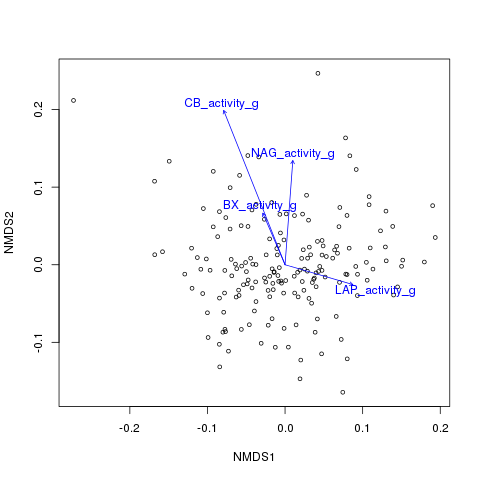

In [29]:
%%R
#ord.fit = envfit(nmds ~ BX_activity_g + CB_activity_g + LAP_activity_g + NAG_activity_g, plantsd)
ord.fit = envfit(nmds ~ BX_activity_g + CB_activity_g + LAP_activity_g + NAG_activity_g, plantenz)
sol = nmds
NMDS = data.frame(MDS1 = sol$points[,1], MDS2 = sol$points[,2])
#plot(nmds)
#plot(ord.fit)
ord.fit %>% print
enz_scores = data.frame(scores(ord.fit, "vectors")) 
enz_scores$var = c("BX", "CB", "LAP", "NAG")
enz_scores %>% print
plot(nmds)
plot(ord.fit)

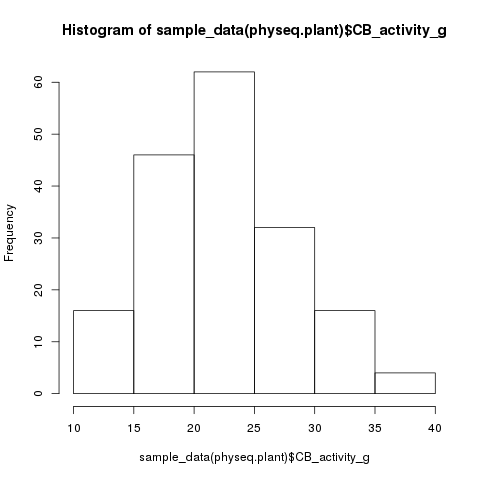

In [63]:
%%R
hist(sample_data(physeq.plant)$CB_activity_g)


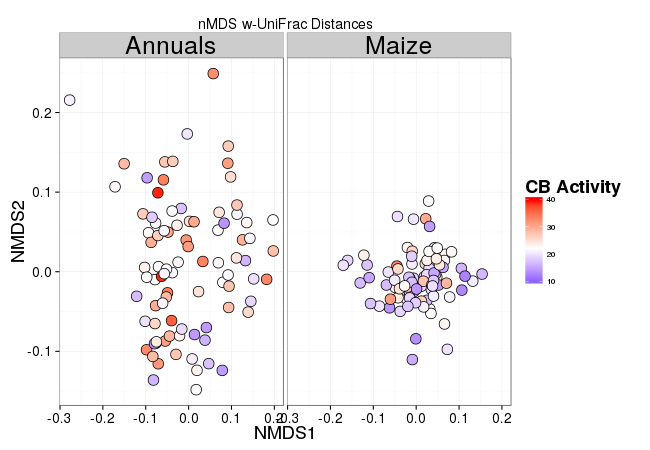

In [65]:
%%R -w 650 -h 450


# generating plot with enzyme activity of LAP as coloring 
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(color=LAP_dif), size = 7, pch=21)+
        geom_point(size = 5, pch = 21, aes(fill = CB_activity_g)) +
        scale_fill_gradient2(name = "CB Activity", limits=c(10,40), low = "blue", high = "red", midpoint = 22) + 
    #geom_segment(data=enz_scores,aes(x=0,xend=NMDS1,y=0,yend=NMDS2),
     # arrow = arrow(length = unit(0.5, "cm")),colour="grey",inherit_aes=FALSE)+
        #geom_text(data=enz_scores,aes(x=NMDS1,y=NMDS2,label=var),size=5) +
        facet_wrap(~Maize) +
        theme_bw() +
        theme(axis.text = element_text(size = 14), 
              axis.title = element_text(size = 18),
             strip.text = element_text(size=25)) +
        theme(legend.title = element_text(colour = 'black', angle = 0, size = 18, 
                                          hjust = 3, vjust = 7, face = 'bold')) +
        theme(legend.text = element_text(size = 8)) +
        #theme(legend.key.size = unit(1, "cm"))+
        labs(title = "nMDS w-UniFrac Distances", size = 20)

p1
#ggsave(filename = "facet_NMDS_w-enz.pdf", plot = p1)

# Beta-diversity hypothesis testing on plant subset 
*Note that maize/non-maize variable should be tested too, for consistency

In [49]:
%%R
colnames(df)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "Leaf_N"             
[25] "LeafC_N"             "LNa"                 "Plant_N"            
[28] "Plant_C"             "Plant_CN"            "d15N"               
[31] "tN_p"                "BX_activity_g"       "CB_activity_g"      
[34] "LAP_activity_g"      "NAG_activity_g"      "BX_dif"             
[37] "CB_dif"              "LAP_dif"             "NAG_dif"            
[40] "BX_rel"              "CB_rel"              "LAP_rel"            
[43] "

In [51]:
%%R
df = as(sample_data(physeq.plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ tN_p + DAP + Plant + Treatment + Rep, df)
plantadonis


Call:
adonis(formula = d ~ tN_p + DAP + Plant + Treatment + Rep, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
tN_p        1    0.4263 0.42627  31.907 0.09773  0.001 ***
DAP         1    0.2117 0.21170  15.846 0.04854  0.001 ***
Plant      20    1.6049 0.08024   6.006 0.36796  0.001 ***
Treatment   1    0.0420 0.04198   3.142 0.00962  0.004 ** 
Rep         1    0.0593 0.05933   4.441 0.01360  0.001 ***
Residuals 151    2.0173 0.01336         0.46254           
Total     175    4.3615                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [52]:
%%R
#Compare bray to w-unifrac
df = as(sample_data(physeq.plant), "data.frame")
d = plant.bray.dist
plantadonis = adonis(d ~ DAP + Plant + Treatment, df)
plantadonis


Call:
adonis(formula = d ~ DAP + Plant + Treatment, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         1    1.3220 1.32197 15.7127 0.06115  0.001 ***
Plant      20    7.1939 0.35970  4.2753 0.33276  0.001 ***
Treatment   1    0.2303 0.23031  2.7374 0.01065  0.001 ***
Residuals 153   12.8725 0.08413         0.59543           
Total     175   21.6187                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


*Note: what OTUs are influenced by fertilization treatment?

In [124]:
%%R
plant_group = get_variable(physeq.plant, "Plant")
d = plant.wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Call:
anosim(dat = d, grouping = plant_group) 
Dissimilarity: 

ANOSIM statistic R: 0.5934 
      Significance: 0.001 

Permutation: free
Number of permutations: 999

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0229 0.0295 0.0347 0.0431 

Dissimilarity ranks between and within classes:
         0%     25%    50%      75%  100%     N
Between   1 4134.75 7936.5 11670.25 15400 14784
75-062   42  378.50  999.0  3114.50  8061    28
ABUTH    70 2466.50 6506.0 13033.50 15131    28
AMAPO    17  927.25 2764.5  5019.25 13047    28
B73     104  901.00 3708.5  9620.75 12105    28
B97      31  925.50 1528.0  4483.00  8971    28
ECHCG    22 4923.00 8179.0 12673.75 14619    28
ELCOR    38  376.25 1539.5  3906.00 10158    28
ERATE    20  723.00 2102.5  5215.25 14227    28
FAGES     2   15.50   79.0   321.25  2160    28
GLYMA   510 4319.00 8780.5 11514.50 15068    28
H99      72 1217.25 2842.5  4501.75  6104    28
HELAN    81 1004.00 1681.5  2865.75  8332    28
Hp301  

### Beta-diversity hypothesis tests on just maize

## Now on just non-maize Need to fix

In [101]:
%%R
sample_data(physeq.plant)$Maize

  [1] Maize   Maize   Annuals Maize   Maize   Maize   Annuals Annuals Annuals
 [10] Maize   Maize   Maize   Annuals Maize   Maize   Maize   Annuals Maize  
 [19] Maize   Annuals Maize   Maize   Maize   Annuals Maize   Maize   Annuals
 [28] Maize   Annuals Maize   Maize   Maize   Annuals Maize   Maize   Maize  
 [37] Maize   Maize   Maize   Annuals Maize   Maize   Maize   Annuals Annuals
 [46] Maize   Maize   Maize   Maize   Maize   Maize   Annuals Annuals Annuals
 [55] Maize   Annuals Maize   Annuals Maize   Maize   Maize   Annuals Maize  
 [64] Maize   Annuals Annuals Annuals Maize   Maize   Maize   Maize   Annuals
 [73] Maize   Maize   Maize   Annuals Annuals Maize   Annuals Annuals Annuals
 [82] Annuals Maize   Maize   Annuals Annuals Annuals Annuals Annuals Maize  
 [91] Annuals Annuals Annuals Annuals Maize   Annuals Annuals Annuals Annuals
[100] Annuals Annuals Annuals Maize   Annuals Annuals Maize   Annuals Annuals
[109] Maize   Maize   Annuals Annuals Annuals Maize   Annuals Ma

In [106]:
%%R
plant.nm = subset_samples(physeq.plant, Maize == "Annuals")
plant.m = subset_samples(physeq.plant, Maize == "Maize")
plant.nm
plant.m

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10493 taxa and 88 samples ]
sample_data() Sample Data:       [ 88 samples by 44 sample variables ]
tax_table()   Taxonomy Table:    [ 10493 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 10493 tips and 10492 internal nodes ]


In [108]:
%%R
registerDoParallel(cores=28)

maize.wunif.dist = phyloseq::distance(plant.m, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

nm.wunif.dist = phyloseq::distance(plant.nm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

# Test correlation between enzyme activity and microbial community composition

In [80]:
%%R
colnames(Sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Biomass_P"           "SLA"                 "Leaf_N"             
[25] "LeafC_N"             "LNa"                 "Plant_N"            
[28] "Plant_C"             "Plant_CN"            "d15N"               
[31] "tN_p"                "BX_activity_g"       "CB_activity_g"      
[34] "LAP_activity_g"      "NAG_activity_g"      "BX_dif"             
[37] "CB_dif"              "LAP_dif"             "NAG_dif"            
[40] "BX_rel"              "CB_rel"              "LAP_rel"            
[43] "


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = full.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.02324 
      Significance: 0.187 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0364 0.0467 0.0586 0.0714 
Permutation: free
Number of permutations: 999



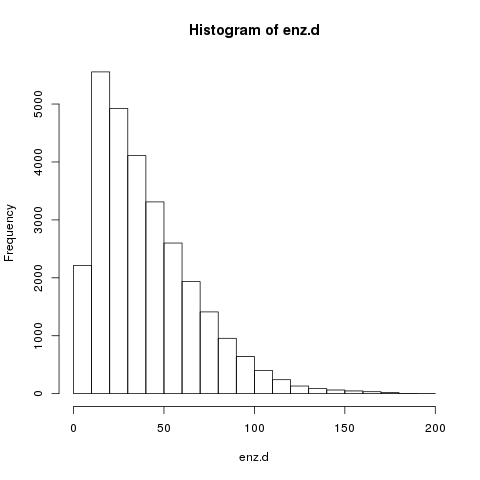

In [89]:
%%R
#Test on soil activity/rhizosphere effect
Sd = sample_data(physeq.thresh)
enz.d = dist(Sd[,32:35], method = "euclidian")
hist(enz.d)
M1 = mantel(full.wunif.dist, enz.d, method="pearson", permutations=999)
M1
#Model is not significant within just plants or within entire dataset


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = plant.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.00774 
      Significance: 0.501 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0558 0.0813 0.0977 0.1187 
Permutation: free
Number of permutations: 999



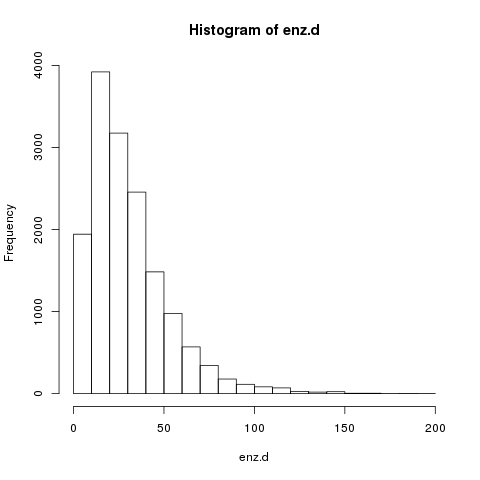

In [93]:
%%R
#Test on "difference" rhizosphere effect
Sd = sample_data(physeq.plant)
enz.d = dist(Sd[,36:39], method = "euclidean")
hist(enz.d)
M1 = mantel(plant.wunif.dist, enz.d, method="pearson", permutations=999)
M1
#Model is not significant based on difference calculation

$breaks
 [1] 0.0 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.6 1.8 2.0 2.2 2.4 2.6 2.8 3.0 3.2 3.4 3.6
[20] 3.8

$counts
 [1]  292 2149 3204 3068 2337 1661  976  578  321  172  117   95   84   76   66
[16]   85   66   35   18

$density
 [1] 0.094805195 0.697727273 1.040259740 0.996103896 0.758766234 0.539285714
 [7] 0.316883117 0.187662338 0.104220779 0.055844156 0.037987013 0.030844156
[13] 0.027272727 0.024675325 0.021428571 0.027597403 0.021428571 0.011363636
[19] 0.005844156

$mids
 [1] 0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7

$xname
[1] "enz.d"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = plant.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1135 
      Significance: 0.027 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0628 0.0869 0.1139 0.1371 
Permutation: free
Number of permutations: 999

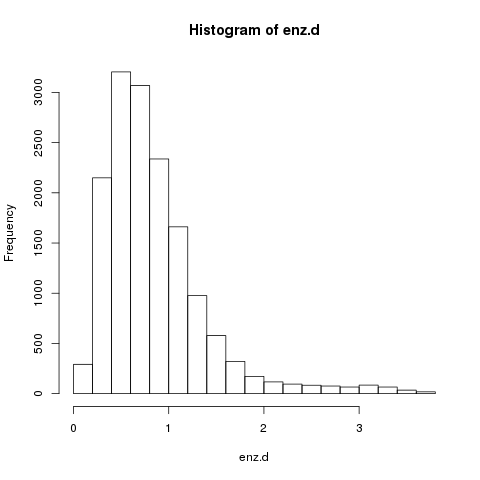

In [111]:
%%R
#Test on relative rhizosphere effect
Sd = sample_data(physeq.plant)
enz.d = dist(Sd[,40:43], method = "euclidian")
print(hist(enz.d))
M1 = mantel(plant.wunif.dist, enz.d, method="pearson", permutations=999)
print(M1)



$breaks
[1] 0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0

$counts
[1] 1113 1797  668  149   16   14   58   13

$density
[1] 0.581504702 0.938871473 0.349007315 0.077847440 0.008359457 0.007314525
[7] 0.030303030 0.006792059

$mids
[1] 0.25 0.75 1.25 1.75 2.25 2.75 3.25 3.75

$xname
[1] "enz.d"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = maize.wunif.dist, ydis = enz.d, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1204 
      Significance: 0.066 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.097 0.136 0.166 0.195 
Permutation: free
Number of permutations: 999

$breaks
 [1] 0.0 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.6 1.8 2.0 2.2 2.4 2.6 2.8 3.0 3.2 3.4 3.6
[20] 3.8

$counts
 [1]  55 543 766 748 589 420 239 149  80  51  42  46  29  30  13  18   6   3   1

$density
 [1] 0.071839080 0.709247649 1.000522466 0.977011494 0.769331243 0.548589342
 [7] 0.312173459 0.1946

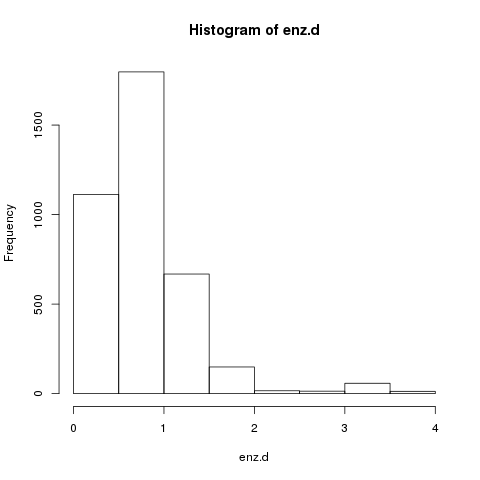

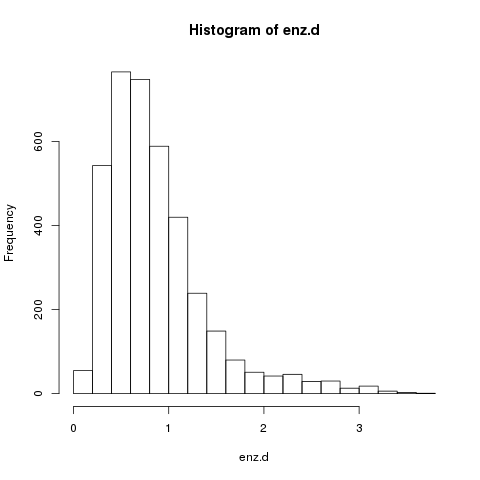

In [112]:
%%R
#Test if rel effect is different when comparing among maize or non-maize
Sd = sample_data(plant.m)
enz.d = dist(Sd[,40:43], method = "euclidian")
print(hist(enz.d))
M1 = mantel(maize.wunif.dist, enz.d, method="pearson", permutations=999)
print(M1)

Sd = sample_data(plant.nm)
enz.d = dist(Sd[,40:43], method = "euclidian")
print(hist(enz.d))
M1 = mantel(nm.wunif.dist, enz.d, method="pearson", permutations=999)
print(M1)

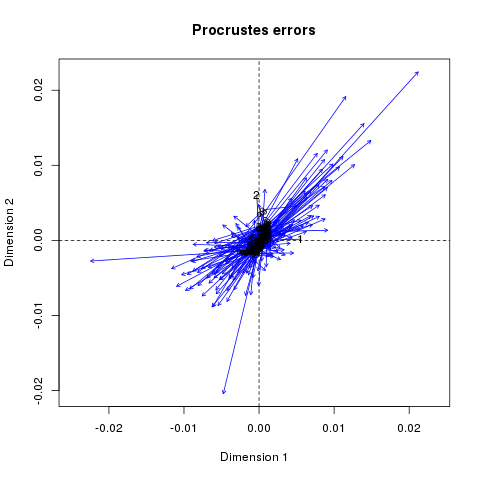

In [96]:
%%R
 p1 = protest(plant.wunif.dist, enz.d, scores = "sites", permutations = 999)
plot(p1)